## 公式Example

>深層学習フレームワークには公式に様々なモデルのExampleコードが公開されています。

## 【問題1】公式チュートリアルモデルを分担して実行
>TensorFLowの公式チュートリアルモデルを分担して実行してください。
>
>以下の中から1人ひとつ選び実行し、その結果を簡単に発表してください。
>
>models/tutorials at master · tensorflow/models

## 創造的な組織 「DeepDream」

このチュートリアルには、Alexander Mordvintsevによるこのブログ投稿で説明されているように、DeepDreamの最小限の実装が含まれています。

**DeepDream**は、<font color="Red">ニューラルネットワークによって学習されたパターンを視覚化する実験</font>です。  
子供が雲を見てランダムな形を解釈しようとするときと同様に、DeepDreamは、**画像に表示されるパターン**を過剰に解釈して強化します。

これは、ネットワークを介して画像を転送し、特定のレイヤーのアクティブ化に関する**画像の勾配**を計算することによって行われます。  
次に、**画像が変更**されてこれらのアクティベーションが増加し、ネットワークで見られる**パターンが強化**され、夢のような画像になります。  
このプロセスは「Inceptionism」（ InceptionNetおよび映画Inceptionへの参照）と呼ばれていました。

ニューラルネットワークを「夢」にして、画像に表示されるシュールなパターンを強化する方法を示しましょう。

In [1]:
import tensorflow as tf

In [2]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

### 夢を実現する画像を選択してください
このチュートリアルでは、 labradorの画像を使用しましょう。

In [3]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

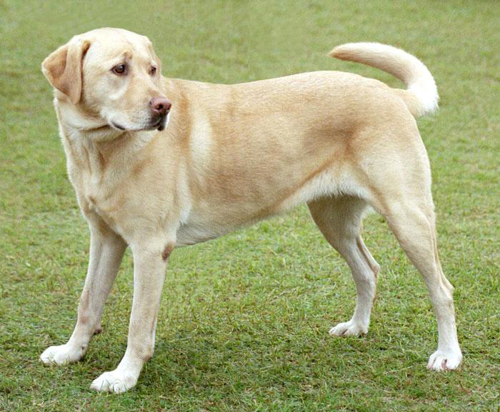

In [4]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

### 特徴抽出モデルを準備する
**事前にトレーニングされた画像分類モデルをダウンロード**して準備します。   
DeepDreamで最初に使用されたモデルと同様の`InceptionV3`を使用します。  
これを変更する場合は、以下のレイヤー名を調整する必要がありますが、 事前にトレーニングされたモデルはすべて機能することに注意してください。

In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

DeepDreamのアイデアは、**1つまたは複数のレイヤーを選択し、画像がレイヤーをますます「励起」するように「損失」を最大化する**ことです。  
組み込まれる機能の複雑さは、選択したレイヤーによって異なります。  
つまり、下のレイヤーはストロークまたは単純なパターンを生成し、深いレイヤーは画像またはオブジェクト全体に洗練された機能を提供します。

**InceptionV3アーキテクチャ**は非常に大きいです（モデルアーキテクチャのグラフについては、TensorFlowのリサーチリポジトリを参照してください）。   
DeepDreamの場合、`対象となるレイヤーは、畳み込みが連結されているレイヤー`です。  
InceptionV3には、`「mixed0」`から`「mixed10」`という名前のこれらのレイヤーが11個あります。  
異なるレイヤーを使用すると、異なる夢のような画像になります。  
**より深いレイヤーはより高いレベルの機能（目や顔など）に応答**し、**以前のレイヤーはより単純な機能（エッジ、形状、テクスチャなど）に応答**します。  
以下で選択したレイヤーを自由に試してみてください。ただし、グラデーションの計算が深いため、レイヤーが深いほど（インデックスが高いレイヤー）、トレーニングに時間がかかることに注意してください。

In [6]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### 損失を計算する
**損失**は、**選択したレイヤーのアクティベーションの合計**です。  
損失は各レイヤーで正規化されるため、大きなレイヤーからの寄与が小さなレイヤーを上回りません。  
通常、損失は勾配降下によって**最小化**したい量です。 DeepDreamでは、`勾配上昇によってこの損失を最大化`します。

In [7]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

### 勾配上昇
選択したレイヤーの損失を計算したら、あとは**画像に関する勾配を計算し、それらを元の画像に追加**するだけです。

**画像にグラデーションを追加すると、ネットワークで見られるパターンが強化されます**。  
各ステップで、ネットワーク内の特定のレイヤーのアクティブ化をますます刺激するイメージを作成します。

以下でこれを行うメソッドは、 tf.functionために`tf.function`にラップされています。  
`input_signature`を使用して、さまざまな画像サイズまたはsteps / step_size値に対して関数がinput_signatureれないようにします。  
詳細については、具象関数ガイドを参照してください。

In [8]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
              tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
              tf.TensorSpec(shape=[], dtype=tf.int32),
              tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [9]:
deepdream = DeepDream(dream_model)

### メインループ

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

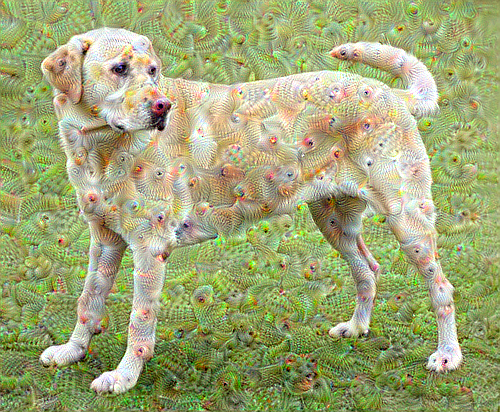

In [11]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

### オクターブを取る

かなり良いですが、この最初の試みにはいくつかの問題があります。

出力に**ノイズ**があります（これはtf.image.total_variation損失で対処できます）。  
画像は**低解像度**です。  
パターンは、すべて**同じ粒度で発生**しているように見えます。  
これらすべての問題に対処する1つのアプローチは、`さまざまなスケールで勾配上昇を適用する`ことです。  
これにより、小さいスケールで生成されたパターンを大きいスケールのパターンに組み込み、追加の詳細を入力することができます。  

これを行うには、**前の勾配上昇アプローチを実行してから、画像のサイズを大きくし（`オクターブ`と呼ばれます）、このプロセスを複数のオクターブに対して繰り返します**。

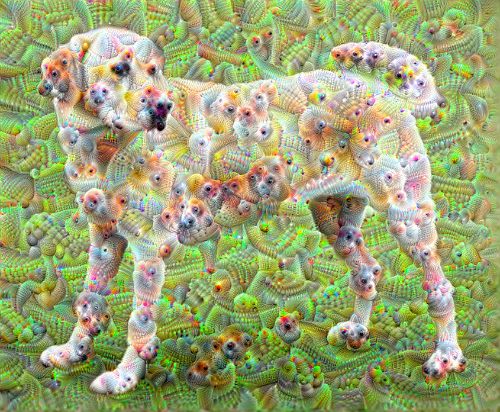

402.9008219242096

In [12]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

### オプション：タイルによるスケールアップ
考慮すべきことの1つは、**画像のサイズが大きくなると、勾配計算を実行するために必要な時間とメモリも大きくなる**ということです。  
上記のオクターブの実装は、非常に大きな画像や多くのオクターブでは機能しません。

この問題を回避するには、`画像をタイルに分割し、各タイルの勾配を計算`します。

各タイル計算の前に`ランダムシフト`を画像に適用すると、タイルの継ぎ目が表示されなくなります。

ランダムシフトを実装することから始めます。

In [13]:
def random_roll(img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0,1])
    return shift, img_rolled


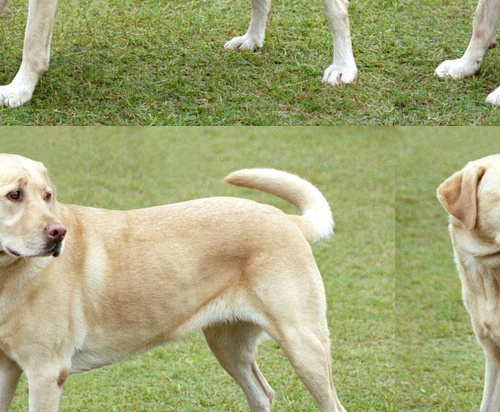

In [14]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

これは、前に定義したdeepdream関数に相当するタイルです。

In [15]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    def __call__(self, img, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)

        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    # This needs gradients relative to `img_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(img_rolled)

                    # Extract a tile out of the image.
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients

In [16]:
get_tiled_gradients = TiledGradients(dream_model)

これを組み合わせると、スケーラブルでオクターブを意識したディープドリームの実装が得られます。

In [17]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print ("Octave {}, Step {}".format(octave, step))
    
    result = deprocess(img)
    return result

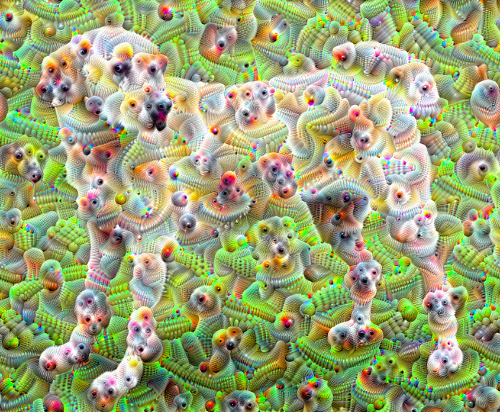

In [18]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

ずっといい！オクターブ数、オクターブスケール、アクティブ化されたレイヤーを試して、DeepDream化された画像の外観を変更します。

読者は、ニューラルネットワークを視覚化して解釈するためにこのチュートリアルで紹介したアイデアを拡張したTensorFlowLucidにも興味があるかもしれません。

## 異なるフレームワークへの書き換え

>「ディープラーニングフレームワーク1」で作成した4種類のデータセットを扱うTensorFLowのコードを異なるフレームワークに変更していきます。
>
>- Iris（Iris-versicolorとIris-virginicaのみの2値分類）
>- Iris（3種類全ての目的変数を使用して多値分類）
>- House Prices
>- MNIST

## Kerasへの書き換え
>KerasはTensorFLowに含まれるtf.kerasモジュールを使用してください。
>
>KerasにはSequentialモデルかFunctional APIかなど書き方に種類がありますが、これは指定しません。

## 【問題3】Iris（2値分類）をKerasで学習
>TensorFlowによるIrisデータセットに対する2値分類をKerasに書き換えてください。

In [423]:
from tensorflow.keras import backend as K

In [424]:
K.clear_session()

In [425]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [426]:
# scikit-learn から　iris データセットを読み込む
from sklearn.datasets import load_iris

# iris データセットを変数に格納する
data = load_iris()

# 行と列のインデックス用のリストを用意
iris_data_columns=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]
iris_target_columns=['Species',]
# pandas のデータフレームにする
X_data = pd.DataFrame(data=data['data'], columns=iris_data_columns)
y_data = pd.DataFrame(data=data['target'], columns=iris_target_columns)

y_data=y_data.replace({0: 'Iris-setosa', 1: 'Iris-versicolor', 2:'Iris-virginica'})

# Xとyを列方向に結合
df = pd.concat([X_data, y_data], axis=1)
df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [427]:
# データフレームから条件抽出
df_q2 = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df_q2["Species"]
X = df_q2.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [428]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [429]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [430]:
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/100
8/8 [==============================] - 0s 54ms/step - loss: 1.7042 - accuracy: 0.5312 - val_loss: 2.0742 - val_accuracy: 0.3750
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 1.5451 - accuracy: 0.5312 - val_loss: 1.8703 - val_accuracy: 0.3750
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 1.3982 - accuracy: 0.5312 - val_loss: 1.6856 - val_accuracy: 0.3750
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 1.2567 - accuracy: 0.5312 - val_loss: 1.5204 - val_accuracy: 0.3750
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 1.1374 - accuracy: 0.5312 - val_loss: 1.3775 - val_accuracy: 0.3750
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 1.0363 - accuracy: 0.5312 - val_loss: 1.2492 - val_accuracy: 0.3750
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.9567 - accuracy: 0.5312 - val_loss: 1.1275 - val_accuracy: 0.3750
Epoch 8/100
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.3757 - accuracy: 0.9688 - val_loss: 0.3876 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3750 - accuracy: 0.9375 - val_loss: 0.3879 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3684 - accuracy: 0.9688 - val_loss: 0.3689 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3655 - accuracy: 0.9688 - val_loss: 0.3622 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3625 - accuracy: 0.9688 - val_loss: 0.3593 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3579 - accuracy: 0.9531 - val_loss: 0.3679 - val_accuracy: 1.0000
Epoch 65/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3541 - accuracy: 0.9531 - val_loss: 0.3574 - val_accuracy: 1.0000
Epoch 66/100
8/8 [===============

In [431]:
y_pred_proba = model.predict(X_test)[:, 0]
print("y_pred_proba", y_pred_proba)

# 確率を0, 1に変換
y_pred = np.where(y_pred_proba >0.5, 1, 0)
print("y_pred", y_pred)

y_pred_proba [0.21659997 0.93220985 0.21213096 0.9306427  0.73887414 0.93025887
 0.4519325  0.6602696  0.94052696 0.82793593 0.86083865 0.87937844
 0.924723   0.34924394 0.10649899 0.14975107 0.5408198  0.11299902
 0.7298342  0.14827028]
y_pred [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0]


In [432]:
import matplotlib.pyplot as plt

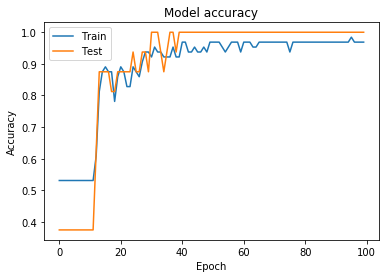

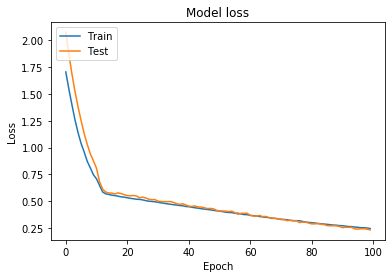

In [433]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 【問題4】Iris（多値分類）をKerasで学習
>TensorFlowによるIrisデータセットに対する3値分類をKerasに書き換えてください。

In [434]:
K.clear_session()

In [435]:
y_multi = df["Species"]
X_multi = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]

# one-hot-encording
y_one = pd.get_dummies(y_multi)

#y = np.array(y_multi)
y = np.array(y_one)
X = np.array(X_multi)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [436]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation = tf.nn.relu, input_shape=(4,)))
model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))#tf.nn.sigmoid

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


In [437]:
model.compile(loss='categorical_crossentropy',#'binary_crossentropy'
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [438]:
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/100
12/12 [==============================] - 0s 16ms/step - loss: 2.7920 - accuracy: 0.3125 - val_loss: 2.5971 - val_accuracy: 0.2917
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 2.2648 - accuracy: 0.3125 - val_loss: 2.1038 - val_accuracy: 0.2917
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.8209 - accuracy: 0.3125 - val_loss: 1.7182 - val_accuracy: 0.2917
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 1.5099 - accuracy: 0.3125 - val_loss: 1.3966 - val_accuracy: 0.2917
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 1.2326 - accuracy: 0.3125 - val_loss: 1.1680 - val_accuracy: 0.3333
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 1.0355 - accuracy: 0.3438 - val_loss: 1.0202 - val_accuracy: 0.3750
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9301 - accuracy: 0.4583 - val_loss: 0.9117 - val_accuracy: 0.4583
Epoch 8/100


Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1357 - accuracy: 0.9792 - val_loss: 0.2550 - val_accuracy: 0.9167
Epoch 60/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1298 - accuracy: 0.9792 - val_loss: 0.2531 - val_accuracy: 0.9167
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1258 - accuracy: 0.9792 - val_loss: 0.2527 - val_accuracy: 0.9167
Epoch 62/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1252 - accuracy: 0.9792 - val_loss: 0.2459 - val_accuracy: 0.9167
Epoch 63/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9792 - val_loss: 0.2508 - val_accuracy: 0.9167
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1216 - accuracy: 0.9792 - val_loss: 0.2447 - val_accuracy: 0.9167
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1200 - accuracy: 0.9792 - val_loss: 0.2549 - val_accuracy: 0.9167
Epoch 

In [439]:
y_pred_proba = model.predict(X_test)
print("y_pred_proba\n", y_pred_proba)

y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred\n", y_pred)

y_pred_proba
 [[2.0148289e-05 3.6388666e-03 9.9634093e-01]
 [7.3090103e-03 9.8500580e-01 7.6851961e-03]
 [9.9690682e-01 3.0931158e-03 6.3188160e-08]
 [1.6972102e-05 1.1426340e-02 9.8855662e-01]
 [9.9047625e-01 9.5228823e-03 8.2592663e-07]
 [4.5633064e-06 1.2084567e-03 9.9878699e-01]
 [9.9267793e-01 7.3216036e-03 5.1960660e-07]
 [2.2657493e-03 9.8298937e-01 1.4744938e-02]
 [2.3706139e-03 9.7232068e-01 2.5308810e-02]
 [9.4016213e-03 9.8296988e-01 7.6285130e-03]
 [5.6140310e-05 1.4319753e-02 9.8562407e-01]
 [3.0396983e-03 9.8316664e-01 1.3793731e-02]
 [3.3704636e-03 8.9857095e-01 9.8058619e-02]
 [2.8923058e-03 9.5735544e-01 3.9752278e-02]
 [3.0182304e-03 8.3425677e-01 1.6272493e-01]
 [9.9299651e-01 7.0030261e-03 5.1750607e-07]
 [3.4787271e-03 8.7642217e-01 1.2009918e-01]
 [4.4911224e-03 7.2889674e-01 2.6661208e-01]
 [9.8558635e-01 1.4411398e-02 2.1861244e-06]
 [9.9564856e-01 4.3513156e-03 1.3489255e-07]
 [6.5634573e-05 1.2660822e-02 9.8727357e-01]
 [3.1274594e-03 6.4613301e-01 3.5073954e-

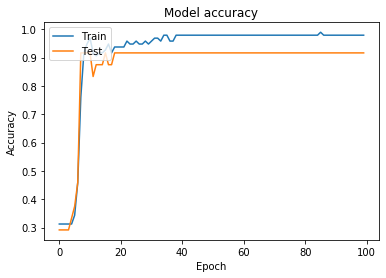

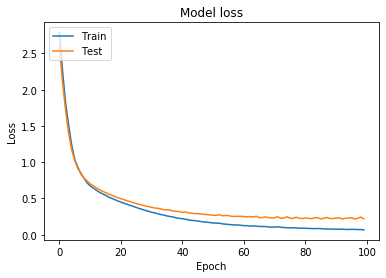

In [440]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 【問題5】House PricesをKerasで学習
>TensorFlowによるHouse Pricesデータセットに対する回帰をKerasに書き換えてください。

In [458]:
K.clear_session()

In [459]:
# データセットの読み込み
csv_path = "./Kaggle_data/train.csv" # ファイル名（パス）を指定する
df_house = pd.read_csv(csv_path)

# データフレームから条件抽出
X = np.array(df_house[['GrLivArea','YearBuilt']])
y = np.array(df_house['SalePrice'])

# 対数変換
X = np.log(np.array(X))
y = np.log(np.array(y))
y=y.reshape(-1,1)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


In [460]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation = tf.nn.relu, input_shape=(2,)))
model.add(tf.keras.layers.Dense(8, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation = tf.nn.relu))#tf.nn.sigmoid, tf.nn.softmax

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [461]:
model.compile(loss='mean_squared_error',#'binary_crossentropy'
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['mean_squared_error'])

In [462]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/100
30/30 [==============================] - 0s 6ms/step - loss: 29.7750 - mean_squared_error: 29.7750 - val_loss: 26.4661 - val_mean_squared_error: 26.4661
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 24.1411 - mean_squared_error: 24.1411 - val_loss: 21.2641 - val_mean_squared_error: 21.2641
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 19.2832 - mean_squared_error: 19.2832 - val_loss: 16.8266 - val_mean_squared_error: 16.8266
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 15.1670 - mean_squared_error: 15.1670 - val_loss: 13.1008 - val_mean_squared_error: 13.1008
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 11.7377 - mean_squared_error: 11.7377 - val_loss: 10.0229 - val_mean_squared_error: 10.0229
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 8.9231 - mean_squared_error: 8.9231 - val_loss: 7.5249 - val_mean_squared_error: 7.5249
Epoch 7/100
30

30/30 [==============================] - 0s 3ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0783 - val_mean_squared_error: 0.0783
Epoch 52/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0785 - val_mean_squared_error: 0.0785
Epoch 53/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0785 - val_mean_squared_error: 0.0785
Epoch 54/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0784 - val_mean_squared_error: 0.0784
Epoch 55/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0783 - val_mean_squared_error: 0.0783
Epoch 56/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0767 - mean_squared_error: 0.0767 - val_loss: 0.0784 - val_mean_squared_error: 0.0784
Epoch 57/100
30/30 [=====================

In [463]:
y_pred_proba = model.predict(X_test)[:, 0]
print("y_pred_proba", y_pred_proba)

y_pred_proba [12.576794  12.103677  11.833863  12.36368   11.743003  11.657716
 12.048277  11.964119  13.167622  11.762054  11.968032  12.177244
 12.350711  11.547544  11.726766  11.924656  12.317757  11.65141
 11.859395  12.2422695 11.975995  11.498865  11.4479065 12.056004
 12.287489  12.184603  12.118333  11.172444  12.1972275 11.843744
 12.227613  12.237607  11.564172  12.454411  12.384804  12.032575
 12.112127  11.528762  12.406613  12.62981   12.420876  11.9586115
 11.936035  12.274829  12.693933  12.201914  11.456491  11.543545
 12.179641  11.574084  12.649963  11.723552  11.94589   11.406116
 12.159393  11.517006  11.996556  12.255792  11.766906  11.4095335
 11.704998  11.697136  11.863183  11.794612  12.182052  12.042803
 11.574977  12.194265  11.860011  12.216534  12.025187  11.719352
 11.590929  12.016916  11.609033  12.165688  11.65086   11.574552
 12.5698395 11.917567  11.590868  11.50986   11.935085  11.65141
 12.778966  11.955934  11.832213  11.979553  11.859115  11.7279

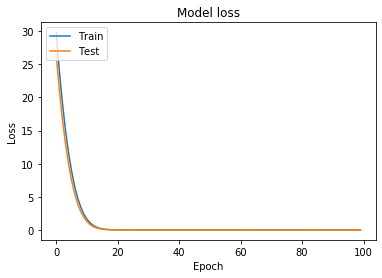

In [464]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 【問題6】MNISTをKerasで学習
>TensorFlowによるMNISTデータセットによる画像の多値分類をKerasに書き換えてください。

In [472]:
K.clear_session()

In [499]:
import tensorflow as tf
import keras

from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder


(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("MNISTのシェイプ")
print(X_train.shape) # (48000, 784)
print(X_test.shape) # (12000, 784)
print(y_train.shape)
print(y_test.shape)

#X_train = X_train.reshape(-1, 784)
#X_test = X_test.reshape(-1, 784)

#X_train = X_train.astype(np.float)
#X_test = X_test.astype(np.float)
#X_train /= 255
#X_test /= 255

#print("平準化後のシェイプ")
#print(X_train.shape) # (48000, 784)
#print(X_test.shape) # (12000, 784)

# 軸を追加
X_train=X_train[:, :, :, np.newaxis]
X_test=X_test[:, :, :, np.newaxis]
print("軸を増やした後のシェイプ")
print(X_train.shape)
print(X_test.shape)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print("ワンホットエンコーディング後のシェイプ")
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

print("train_test_split後のシェイプ")
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

MNISTのシェイプ
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
軸を増やした後のシェイプ
(60000, 28, 28, 1)
(10000, 28, 28, 1)
ワンホットエンコーディング後のシェイプ
(60000,)
(60000, 10)
train_test_split後のシェイプ
(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(12000, 10)


In [500]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28, 28,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

In [502]:
model.compile(loss='categorical_crossentropy',#'binary_crossentropy'
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/50
1500/1500 [==============================] - 152s 101ms/step - loss: 0.3469 - accuracy: 0.9237 - val_loss: 0.0741 - val_accuracy: 0.9765
Epoch 2/50
1500/1500 [==============================] - 157s 105ms/step - loss: 0.0992 - accuracy: 0.9700 - val_loss: 0.0692 - val_accuracy: 0.9797
Epoch 3/50
1500/1500 [==============================] - 141s 94ms/step - loss: 0.0834 - accuracy: 0.9743 - val_loss: 0.0600 - val_accuracy: 0.9803
Epoch 4/50
1500/1500 [==============================] - 128s 85ms/step - loss: 0.0730 - accuracy: 0.9777 - val_loss: 0.0517 - val_accuracy: 0.9846
Epoch 5/50
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0648 - accuracy: 0.9812 - val_loss: 0.0488 - val_accuracy: 0.9860
Epoch 6/50
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.0666 - val_accuracy: 0.9808
Epoch 7/50
1500/1500 [==============================] - 119s 80ms/step - loss: 0.0572 - accuracy: 0.9824 - val_loss:

In [477]:
y_pred_proba = model.predict(X_test)
print("y_pred_proba\n", y_pred_proba)

y_pred = np.argmax(y_pred_proba, axis=1)
print("y_pred\n", y_pred)

y_pred_proba
 [[0.0000000e+00 1.9313404e-23 2.0404148e-24 ... 1.0000000e+00
  7.3341012e-22 4.2788867e-16]
 [5.7823200e-18 9.2578560e-13 1.0000000e+00 ... 3.3659818e-20
  2.5893513e-17 8.2327698e-25]
 [7.4315651e-24 1.0000000e+00 5.9420515e-16 ... 8.9607759e-13
  1.4991672e-10 5.1646760e-14]
 ...
 [0.0000000e+00 1.5936489e-30 5.6151251e-30 ... 8.7625252e-27
  9.9654784e-35 1.8142877e-20]
 [3.0737680e-33 1.4551106e-34 1.0818544e-33 ... 6.1208375e-30
  6.6278492e-24 1.1272603e-28]
 [2.7915552e-17 0.0000000e+00 9.9423335e-24 ... 6.0897656e-16
  9.7502642e-22 2.5793914e-19]]
y_pred
 [7 2 1 ... 4 5 6]


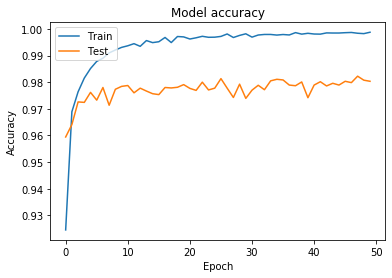

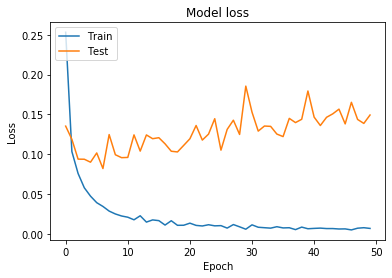

In [478]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

以上